In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow import keras
import os
from sklearn import model_selection
from sklearn import utils
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, roc_auc_score
from scipy import ndimage
from gc import collect
import matplotlib.pyplot as plt
from collections import Counter
from seaborn import heatmap


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
def get_labels(label_file):
    """lê a tabela com as informações dos pacientes e retorna uma matriz com o ID e as labels"""
    labels = pd.read_csv(label_file)
    cancer_labels = dict()

    for p in labels.index:
        cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

    return cancer_labels

In [3]:
labels = get_labels('/kaggle/input/labelsssssss/labels.csv')
numbers_per_class = [0, 0, 0, 0]
for i in labels:
    numbers_per_class[np.argmax(labels[i])] += 1

proportion_per_class = [round(number_of_class/sum(numbers_per_class), 2) for number_of_class in numbers_per_class]
proportion_per_class

[0.35, 0.25, 0.23, 0.17]

In [4]:
path = '/kaggle/input/192x256xdepth/'
dirs = os.listdir(path)

X = [path + i for i in os.listdir(path)]
y = [np.argmax(labels[(path+i)[-14:-4]]) for i in os.listdir(path)]

In [5]:
def balancing_batch(X, y, max_value):
    X, y = utils.shuffle(X, y)
    new_X, new_y = [], []
    counter_class_zero = 0
    counter_class_one = 0
    counter_class_two = 0
    counter_class_three = 0

    max_per_class = max_value//4

    for test_x, test_y in zip(X, y):
        if test_y == [1, 0, 0, 0] and counter_class_zero < max_per_class:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_zero += 1
        elif test_y == [0, 1, 0, 0] and counter_class_one < max_per_class:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_one += 1
        elif test_y == [0, 0, 1, 0] and counter_class_two < max_per_class:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_two += 1
        elif test_y == [0, 0, 0, 1] and counter_class_three < max_per_class:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_three += 1
    
    return np.array(new_X, dtype='float16'), np.array(new_y, dtype='uint8')

In [6]:
def separate_slices(img):
    'function to separate 2d images of 3d original image'
    slices = []

    for i in range(img.shape[-2]):
        slices.append(np.array(img[:, :, i]))

    slices.append(np.mean(img, axis=-2)) #including mean of slices

    return slices

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y,random_state=42, train_size=0.8)

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels_dir, batch_size, sub_batch_size, dim_img, training, shuffle=True):
        self.list_IDs = list_IDs # array of strings with original images name with directory
        self.labels = self.__get_labels(labels_dir) #dict with labels of all images
        self.batch_size = batch_size #3d-images per batch
        self.sub_batch_size = sub_batch_size #quantity of sub-images per batch will be choose to train
        self.dim_img = dim_img # tuple with width and height of image like (192, 256)
        self.training = training # true if generator is for training, false if generator is for validation
        self.shuffle = shuffle # true or false to shuffle data after any epochs
        self.on_epoch_end() # call of the function


    def __get_labels(self, label_file):
        'take the dict with labels of images'
        labels = pd.read_csv(label_file)
        cancer_labels = dict()

        for p in labels.index:
            cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

        return cancer_labels

    def __data_augmentation(self, x):
        'generate variations of images'
        new_images = []
        x = x.astype('float16')
        new_images.append(x)

        x = cv2.flip(x.astype('float32'), 1).astype('float16')

        new_images.append(np.expand_dims(x, -1))

        return utils.shuffle(new_images)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))


    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        if self.training:
            X, y = balancing_batch(X, y, self.sub_batch_size)
            return np.array(X[0:self.sub_batch_size], dtype='float16'), np.array(y[0:self.sub_batch_size], dtype='uint8')
        
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        X = []
        y = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            prev_len_X = len(X)
            full_image = np.load(ID)
            new_images = separate_slices(full_image)
            if self.training:
                for img in new_images:
                    X += self.__data_augmentation(img)
            else:
                X = np.array(new_images, dtype='float16')

            #adding new data labels for y array
            for _ in range(len(X) - prev_len_X):
                y.append(self.labels[ID[-14:-4]]) #'-14:-4 represent a part of string with name of original image that slices was taken'

        X, y = utils.shuffle(X, y)
        return X, y

In [9]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.block_layers = [keras.layers.Conv2D(filters, kernel_size=(3,4), strides=strides, padding='same', use_bias=False),
                             keras.layers.BatchNormalization(),
                             self.activation,
                             keras.layers.Conv2D(filters, kernel_size=(3,4), strides=1, padding='same', use_bias=False),
                             keras.layers.BatchNormalization()]

        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [keras.layers.Conv2D(filters, kernel_size=(1,1), strides=strides, padding='same', use_bias=False),
                                keras.layers.BatchNormalization()]

    def call(self, x):
        inputs = x

        for layer in self.block_layers:
            x = layer(x)

        for layer in self.skip_layers:
            inputs = layer(inputs)

        return self.activation(x + inputs)

def get_resnet34():
    resnet34 = keras.models.Sequential()
    resnet34.add(keras.layers.Conv2D(filters=64, kernel_size=(7,9), strides=2, padding='same', use_bias=False, input_shape=(192, 256, 1)))
    resnet34.add(keras.layers.BatchNormalization())
    resnet34.add(keras.layers.Activation(keras.activations.relu))
    resnet34.add(keras.layers.MaxPool2D(pool_size=(3,4), strides=2, padding='same'))

    prev_filters = 64
    for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
        if filters == prev_filters :
            strides = 1
        else:
            strides = 2

        resnet34.add(ResidualUnit(filters, strides))
        prev_filters = filters

    resnet34.add(keras.layers.GlobalAvgPool2D())
    resnet34.add(keras.layers.Flatten())
    resnet34.add(keras.layers.Dense(units=4, activation='sigmoid'))

    return resnet34

In [24]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1,
                  checkpoint_callback_auc2,
                  checkpoint_callback_auc3,
                  checkpoint_callback_auc4,
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [25]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]

    # Generators
    training_generator = DataGenerator(list_IDs=train,
                                       labels_dir='/kaggle/input/labelsssssss/labels.csv',
                                       dim_img=(192, 256),
                                       batch_size=5,
                                       sub_batch_size=200,
                                       shuffle=True,
                                       training=True)

    validation_generator = DataGenerator(list_IDs=val,
                                         labels_dir='/kaggle/input/labelsssssss/labels.csv',
                                         dim_img=(192, 256),
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True,
                                         training=False)

    resnet = get_resnet34()

    resnet.compile(loss='categorical_crossentropy',
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])


    # Train model on dataset
    histories.append(resnet.fit(training_generator,
                                   validation_data=validation_generator,
                                   epochs=50,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/50
29/29 [==============================] - 120s 3s/step - loss: 1.7904 - AUC_1: 0.4935 - accuracy: 0.3377 - precision: 0.2471 - recall: 0.8055 - val_loss: 1.3168 - val_AUC_1: 0.6557 - val_accuracy: 0.5933 - val_precision: 0.3433 - val_recall: 0.6866 - lr: 9.0000e-05
Epoch 2/50
29/29 [==============================] - 70s 2s/step - loss: 1.5591 - AUC_1: 0.5617 - accuracy: 0.3451 - precision: 0.2545 - recall: 0.8393 - val_loss: 1.3667 - val_AUC_1: 0.5344 - val_accuracy: 0.4410 - val_precision: 0.2940 - val_recall: 0.8819 - lr: 8.1000e-05
Epoch 3/50
29/29 [==============================] - 68s 2s/step - loss: 1.3752 - AUC_1: 0.6097 - accuracy: 0.3202 - precision: 0.2632 - recall: 0.9555 - val_loss: 1.3825 - val_AUC_1: 0.5513 - val_accuracy: 0.2500 - val_precision: 0.2500 - val_recall: 1.0000 - lr: 7.2900e-05
Epoch 4/50
29/29 [==============================] - 63s 2s/step - loss: 1.3463 - AUC_1: 0.6379 - accuracy: 0.3594 - precision: 0.2739 - recall: 0.9463 - val_loss: 

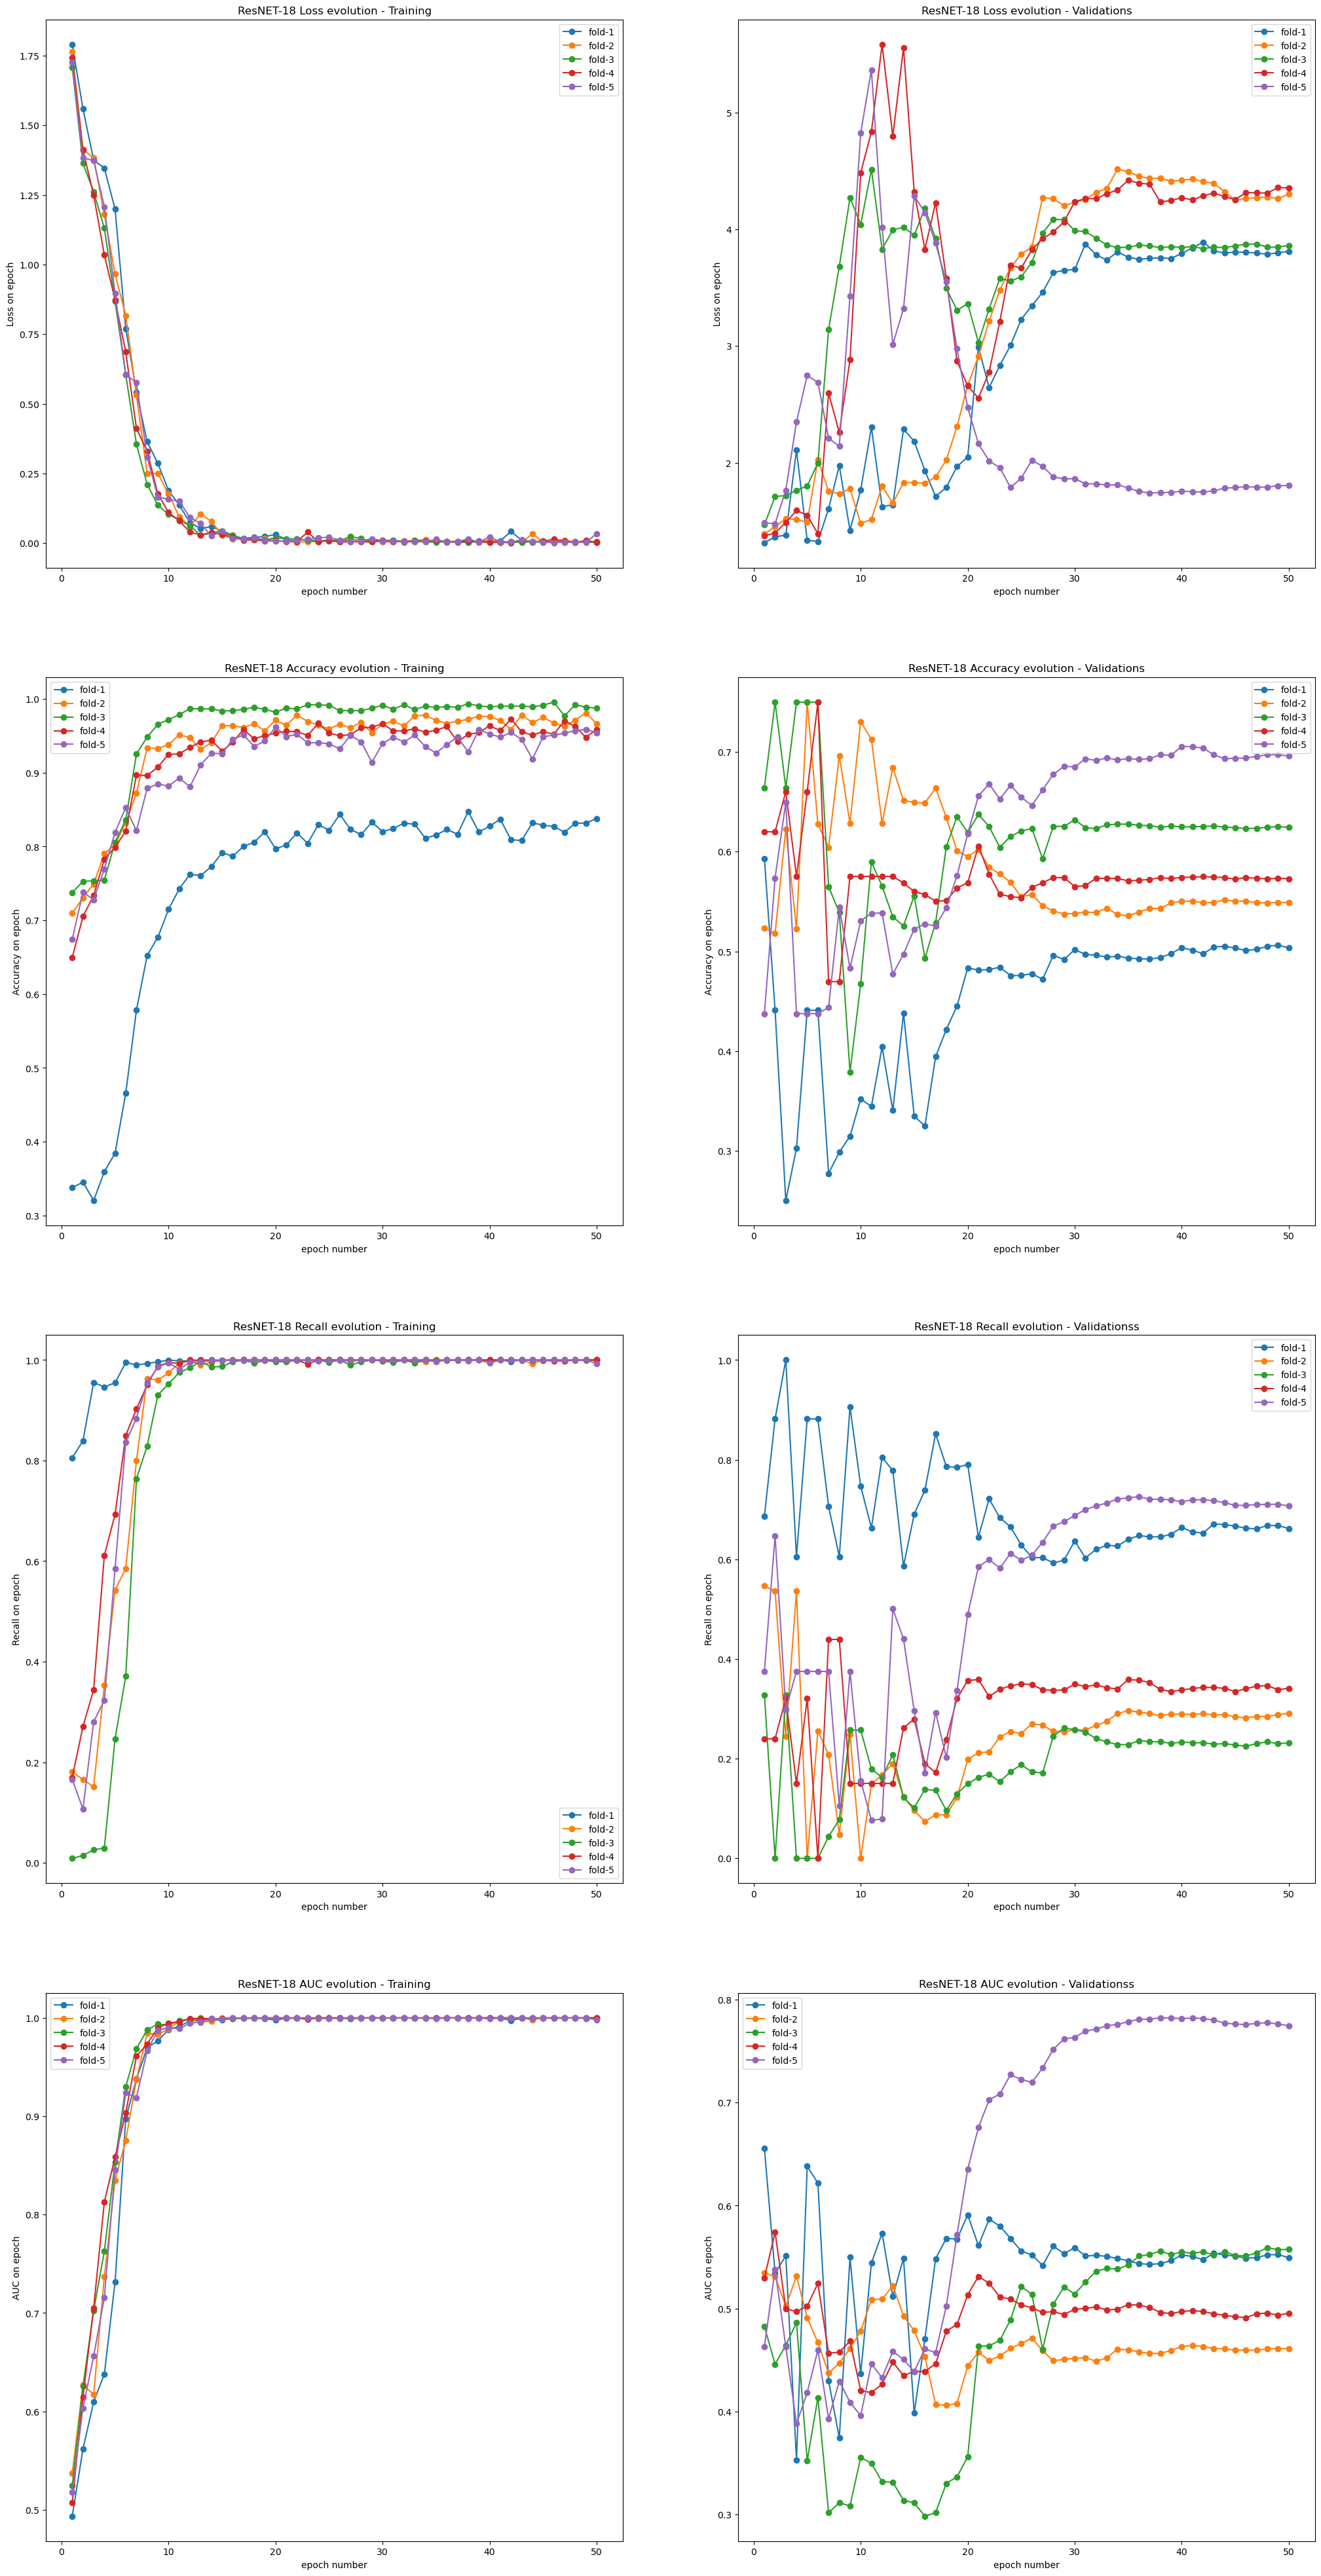

In [26]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 51)), h.history['loss'], marker='o')
    plt.title('ResNET-18 Loss evolution - Training')
    plt.xlabel('epoch number')
    plt.ylabel('Loss on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 51)), h.history['val_loss'], marker='o')
    plt.title('ResNET-18 Loss evolution - Validations')
    plt.xlabel('epoch number')
    plt.ylabel('Loss on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 3)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 51)), h.history['accuracy'], marker='o')
    plt.title('ResNET-18 Accuracy evolution - Training')
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 4)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 51)), h.history['val_accuracy'], marker='o')
    plt.title('ResNET-18 Accuracy evolution - Validations')
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 5)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 51)), h.history['recall'], marker='o')
    plt.title('ResNET-18 Recall evolution - Training')
    plt.xlabel('epoch number')
    plt.ylabel('Recall on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 6)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 51)), h.history['val_recall'], marker='o')
    plt.title('ResNET-18 Recall evolution - Validationss')
    plt.xlabel('epoch number')
    plt.ylabel('Recall on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 7)
for i, h in enumerate(histories):
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 51)), h.history[key_auc], marker='o')
    plt.title('ResNET-18 AUC evolution - Training')
    plt.xlabel('epoch number')
    plt.ylabel('AUC on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 8)
for i, h in enumerate(histories):
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 51)), h.history[key_auc_val], marker='o')
    plt.title('ResNET-18 AUC evolution - Validationss')
    plt.xlabel('epoch number')
    plt.ylabel('AUC on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [27]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')

    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")

Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 0.9999996423721313
Best Accuracy in train: 0.8472527265548706
Best Precision in train: 0.6207367181777954
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6556575298309326
Best Accuracy in validation: 0.5933026671409607
Best Precision in validation: 0.3433026671409607
Best Recall in validation: 1.0


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 0.9999979138374329
Best Accuracy in train: 0.9810795187950134
Best Precision in train: 0.929642915725708
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.5346912741661072
Best Accuracy in validation: 0.75
Best Precision in validation: 0.33256617188453674
Best Recall in validation: 0.5468589067459106


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 0.9999991059303284
Best Accuracy in train: 0.9956315755844116
Best Precision in train: 0.9828264117240906
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC

**TESTS**

In [10]:
training_generator = DataGenerator(list_IDs=X_train,
                                   labels_dir='/kaggle/input/labelsssssss/labels.csv',
                                   dim_img=(192, 256),
                                   batch_size=5,
                                   sub_batch_size=400,
                                   shuffle=True,
                                   training=True)

resnet = get_resnet34()

resnet.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(1e-7),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
resnet.load_weights('/kaggle/working/models/auc5/') #start with best AUC in validations
history = resnet.fit(training_generator, epochs=5)

Epoch 1/5
35/35 [==============================] - 144s 3s/step - loss: 0.3820 - AUC: 0.9385 - accuracy: 0.8524 - precision: 0.6508 - recall: 0.8840
Epoch 2/5
35/35 [==============================] - 60s 2s/step - loss: 0.3073 - AUC: 0.9469 - accuracy: 0.8735 - precision: 0.6973 - recall: 0.8727
Epoch 3/5
35/35 [==============================] - 59s 2s/step - loss: 0.2383 - AUC: 0.9601 - accuracy: 0.9065 - precision: 0.7794 - recall: 0.8733
Epoch 4/5
35/35 [==============================] - 66s 2s/step - loss: 0.2107 - AUC: 0.9693 - accuracy: 0.9145 - precision: 0.7945 - recall: 0.8877
Epoch 5/5
35/35 [==============================] - 62s 2s/step - loss: 0.1915 - AUC: 0.9725 - accuracy: 0.9264 - precision: 0.8278 - recall: 0.8907


In [11]:
res = []
for x in X_test:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = resnet.predict(np.array(x), verbose=0)
    pred = pred.sum(axis=0)
    res.append(np.argmax(pred))

In [12]:
matrix_confusion = np.array([[0, 0, 0, 0],
                             [0, 0, 0, 0],
                             [0, 0, 0, 0],
                             [0, 0, 0, 0]])

for y_pred, y_true in zip(res, y_test):
    matrix_confusion[y_pred][y_true] += 1

print(matrix_confusion)

[[13  2  2  1]
 [ 0 10  0  0]
 [ 2  0  8  1]
 [ 1  0  1  4]]
